# Modelo resuelto con heurísticas

* [Preprocesamiento de datos](#Preprocesamiento-de-datos)
* [Heurísticas](#Heurísticas)

## Preprocesamiento de datos 

In [1]:
import pandas as pd
from gurobipy import *
from pyomo.environ import *

In [2]:
xls = pd.ExcelFile('Proyecto_1_TransporteMaritimo_Dataset1.xlsx', engine='openpyxl')
nombres= xls.sheet_names
df1 = pd.read_excel(xls, nombres[0])
df2 = pd.read_excel(xls, nombres[1])
df3= pd.read_excel(xls, nombres[2])
df4= pd.read_excel(xls, nombres[3])
df5= pd.read_excel(xls, nombres[4])

Se transforman los datos de los dataframes a diccionarios para el procesamiento de datos

In [3]:
barcos_sheet = df1.to_dict("index")
compatibilidad_sheet = df2.to_dict()
cargos_sheet = df3.to_dict("index")
costos_transporte_sheet = df4.to_dict("index")
costos_transporte_dict = {(costos_transporte_sheet[i]['ID_Barco'],costos_transporte_sheet[i]['Puerto_Origen'],costos_transporte_sheet[i]['Puerto_Destino']) : {'Tiempo_Viaje_hrs':costos_transporte_sheet[i]['Tiempo_Viaje_hrs'], 'Costo_Viaje_libras':costos_transporte_sheet[i]['Costo_Viaje_libras']} for i in costos_transporte_sheet.keys()}
costos_tiempo_sheet = df5.to_dict("index")
costos_tiempo_dict = {(costos_tiempo_sheet[i]['ID_Barco'],costos_tiempo_sheet[i]['ID_Cargo']) : {'Tiempo_Origen_hrs':costos_tiempo_sheet[i]['Tiempo_Origen_hrs'], 'Costos_Origen_hrs':costos_tiempo_sheet[i]['Costos_Origen_hrs'], 'Tiempo_Destino_hrs':costos_tiempo_sheet[i]['Tiempo_Destino_hrs'], 'Costos_Destino_hrs':costos_tiempo_sheet[i]['Costos_Destino_hrs']} for i in costos_tiempo_sheet.keys()}

In [4]:
n_cargos = len([cargos_sheet[i]['ID_Cargo'] for i in cargos_sheet.keys() if cargos_sheet[i]['ID_Cargo']>=0])

 La manera en que funcionan los nodos es: los primeros $n$ ($n =$ número de cargos) son los nodos de carga, los siguientes $n$ son los nodos de descarga, los siguientes $v$ ($v =$ número de barcos) son los nodos de origen, y los último v son los nodos de destino.

In [5]:
V = [1+i for i in barcos_sheet.keys()] ## conjunto barcos
n_barcos = len(V)

In [6]:
Kv= {} # conjunto capacidades de barcos
for i in barcos_sheet.keys():
    Kv[barcos_sheet[i]['ID_Barco']] =  barcos_sheet[i]['Capacidad']

In [7]:
# N^P
nodos_carga= [cargos_sheet[i]['ID_Cargo'] for i in cargos_sheet.keys() if cargos_sheet[i]['ID_Cargo']>=0]

#N^D
nodos_descarga= [i+len(nodos_carga) for i in range(1,len(nodos_carga)+1)] ##conjunto nodos de descarga

In [8]:
nodos = {}
for i in range(n_cargos):
    nodos[cargos_sheet[i]['ID_Cargo']] = {'ID_Cargo': cargos_sheet[i]['ID_Cargo'],
                                          'ID_Puerto': cargos_sheet[i]['ID_Puerto_Origen'],
                                          'Tamano': cargos_sheet[i]['Tamano'],
                                          'Costo_SPOT': cargos_sheet[i]['Costo_SPOT'],
                                          'LT': cargos_sheet[i]['LT_Carga'],
                                          'RT': cargos_sheet[i]['RT_Carga']}
    
    nodos[cargos_sheet[i]['ID_Cargo']+n_cargos] = {'ID_Cargo': cargos_sheet[i]['ID_Cargo'],
                                          'ID_Puerto': cargos_sheet[i]['ID_Puerto_Destino'],
                                          'Tamano': cargos_sheet[i]['Tamano'],
                                          'Costo_SPOT': cargos_sheet[i]['Costo_SPOT'],
                                          'LT': cargos_sheet[i]['LT_Descarga'],
                                          'RT': cargos_sheet[i]['RT_Descarga']}
o = {}
d = {}
for v in V:
    o[v] = n_cargos*2+v
    nodos[n_cargos*2+v] = {'Costo_SPOT': 0,
                           'ID_Cargo': 0,
                           'ID_Puerto': barcos_sheet[v-1]['ID_Puerto '],
                           'LT': barcos_sheet[v-1]['Tiempo_Inicio'],
                           'RT': barcos_sheet[v-1]['Tiempo_Inicio'],
                           'Tamano': 0}
    d[v] = n_cargos*2+n_barcos+v
    nodos[n_cargos*2+n_barcos+v] = {'Costo_SPOT': 0,
                                    'ID_Cargo': 0,
                                    'ID_Puerto': 0,
                                    'LT': 100000,
                                    'RT': 100000,
                                    'Tamano': 0}

In [9]:
compatibilidad = {}
for i in V:
    compatibilidad[i] = [int(j) for j in list(df2.loc[i-1])[1:] if j>0]
compatibilidad

Nv = {}
for i in V:
    Nv[i] = []
    for j in nodos.keys():
        if nodos[j]["ID_Cargo"] in compatibilidad[i] or (j == i+n_cargos*2 or j==i+n_cargos*2+len(V)): 
            Nv[i].append(j)

In [10]:
"""import itertools
Av = {}
for v in V:
    Av[v] = list(itertools.permutations(Nv[v],2))
"""
Av={}
indices = []
for v in V:
    Av[v] = [] 
    for i in Nv[v]:
        for j in Nv[v]:
                Av[v].append((i,j))
                indices.append((i,j,v))
indices = tuplelist(indices)

In [11]:
NP_v = {}
for v in V:
    NP_v[v] = [i for i in nodos_carga if i in Nv[v]]

ND_v = {}
for v in V:
    ND_v[v] = [i for i in nodos_descarga if i in Nv[v]]


In [12]:
LT_i = {i:nodos[i]["LT"] for i in nodos.keys()} #lower bounds ventana de tiempo por nodo
RT_i = {i:nodos[i]["RT"] for i in nodos.keys()} #upper bounds ventana de tiempo por nodo


In [13]:
T_ijv={} # tiempo de entre i y j (tiempo de viaje + tiempo de operación en i)
for i in nodos.keys():
    T_ijv[i] = {} 
    for j in nodos.keys():
        T_ijv[i][j] = {} 
        for v in V:
            cargo_i= nodos[i]["ID_Cargo"]
            cargo_j = nodos[j]["ID_Cargo"]
            if i>n_cargos*2+len(V) or j>n_cargos*2+len(V):
                T_ijv[i][j][v] = 0
            else: 
                puerto_origen = nodos[i]["ID_Puerto"]
                puerto_destino = nodos[j]["ID_Puerto"]
                T_ijv[i][j][v] = costos_transporte_dict[v,puerto_origen,puerto_destino]['Tiempo_Viaje_hrs']
                if 0<i<=n_cargos and (i,j) in Av[v]: 
                    T_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Tiempo_Origen_hrs']
                if n_cargos*2>=i>n_cargos and (i,j) in Av[v]:
                    T_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Tiempo_Destino_hrs']
                
                # se les asigna tiempo de operación igual a 0 a los (i,j) que no pertenecen a Av
                # los (i,j) que no pertenecen a Av aún tienen el tiempo entre el puerto de i y j

In [14]:
C_ijv={} # costo de entre i y j (costo de viaje + costo de operación en i)
for i in nodos.keys():
    C_ijv[i] = {} 
    for j in nodos.keys():
        C_ijv[i][j] = {} 
        for v in V:
            cargo_i= nodos[i]["ID_Cargo"]
            cargo_j = nodos[j]["ID_Cargo"]
            if i>n_cargos*2+len(V) or j>n_cargos*2+len(V):
                C_ijv[i][j][v] = 0
            else: 
                puerto_origen = nodos[i]["ID_Puerto"]
                puerto_destino = nodos[j]["ID_Puerto"]
                C_ijv[i][j][v] = costos_transporte_dict[v,puerto_origen,puerto_destino]['Costo_Viaje_libras']
                if i==11 and j==2 and i==1:
                    print(C_ijv[i][j][v])
                if 0<i<=n_cargos and (i,j) in Av[v]:
                    C_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Costos_Origen_hrs']

                if n_cargos*2>=i>n_cargos and (i,j) in Av[v]:
                    C_ijv[i][j][v] += costos_tiempo_dict[v,cargo_i]['Costos_Destino_hrs']

In [15]:
Qj={i:nodos[i]["Tamano"] for i in nodos.keys()}

Cs = {cargos_sheet[i]['ID_Cargo']:cargos_sheet[i]['Costo_SPOT'] for i in cargos_sheet.keys()}

In [16]:
nodos_index = [i for i in nodos.keys()]

## Heurísticas

Se define la función objetivo y las restricciones del modelo

In [17]:
def obj_rule(model):
    return sum(C_ijv[i][j][v]*model.x[i,j,v]  for v in V for (i,j) in Av[v])+sum(Cs[i]*model.y[i] for i in nodos_carga)

def const_1(model, i):
    #return sum(model.x[i,j,v]  for v in V for j in Nv[v]) + model.y[i] == 1
    return sum(model.x[i,j,v]  for v in V for j in Nv[v] if i in Nv[v]) + model.y[i] == 1

def const_2(model, v):
    #return sum(model.x[o[v],j,v] for j in Nv[v]) == 1
    return sum(model.x[o[v],j,v] for j in Nv[v] if o[v]!=j) == 1

def const_3(model, i, v):
    if i in Nv[v]:
        if i!=o[v] and i!=d[v]:
            #return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[j,i,v] for j in Nv[v] if j!=i)==0
            return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[j,i,v] for j in Nv[v])==0
    return Constraint.Skip

def const_4(model, v):
    #return sum(model.x[j,d[v],v] for j in Nv[v]) == 1
    return sum(model.x[j,d[v],v] for j in Nv[v] if d[v]!=j) == 1

def const_5(model, i, j, v):
    if j in NP_v[v]:
        if (i,j) in Av[v]:
            return model.l[i,v]+Qj[j]-model.l[j,v]<=Kv[v]*(1-model.x[i,j,v])
    return Constraint.Skip

def const_6(model, i, j, v):
    if j in NP_v[v]:
        if (i,n_cargos+j) in Av[v]:
            return model.l[i,v]-Qj[j]-model.l[n_cargos+j,v]<=Kv[v]*(1-model.x[i,n_cargos+j,v])
    return Constraint.Skip

def const_7(model, i, v):
    if i in NP_v[v]:
        return (0, model.l[i,v], Kv[v])
    return Constraint.Skip

def const_8(model, i, j, v):
    if (i,j) in Av[v]:
        return model.t[i,v]+T_ijv[i][j][v]-model.t[j,v]<=(RT_i[i]+T_ijv[i][j][v])*(1-model.x[i,j,v])
    return Constraint.Skip

def const_9(model, i, v):
    if i in NP_v[v]:
        #return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[n_cargos+i,j,v] for j in Nv[v] if j!=i+n_cargos)==0
        return sum(model.x[i,j,v] for j in Nv[v])-sum(model.x[n_cargos+i,j,v] for j in Nv[v])==0
    return Constraint.Skip

def const_10(model, i, v):
    if i in NP_v[v]:
        return model.t[i,v]+T_ijv[i][n_cargos+i][v]-model.t[n_cargos+i,v]<=0
    return Constraint.Skip
    
def const_11(model, i, v):
    if i in Nv[v]:
        return (LT_i[i], model.t[i,v], RT_i[i])
    return Constraint.Skip

**definir_modelo** retorna una instancia del modelo con sus variables, valor objetivo y restricciones

In [18]:
def definir_modelo():
    #crear modelo
    model_1 = ConcreteModel()
    #definir variables 
    model_1.x = Var(nodos_index, nodos_index, V, within=Binary)
    model_1.y = Var(nodos_carga, within=Binary)
    model_1.t = Var(nodos_index,V)
    model_1.l = Var(nodos_index,V, within=NonNegativeReals)
    #definir VO
    model_1.obj = Objective(rule=obj_rule)
    #definir restricciones
    model_1.const_1 = Constraint(nodos_carga, rule=const_1)
    model_1.const_2 = Constraint(V, rule=const_2)
    model_1.const_3 = Constraint(nodos_index, V, rule=const_3)
    model_1.const_4 = Constraint(V, rule=const_4)
    model_1.const_5 = Constraint(nodos_index, nodos_index, V, rule=const_5)
    model_1.const_6 = Constraint(nodos_index, nodos_index, V, rule=const_6)
    model_1.const_7 = Constraint(nodos_index, V, rule=const_7)
    model_1.const_8 = Constraint(nodos_index, nodos_index, V, rule=const_8)
    model_1.const_9 = Constraint(nodos_index, V, rule=const_9)
    model_1.const_10 = Constraint(nodos_index, V, rule=const_10)
    model_1.const_11 = Constraint(nodos_index, V, rule=const_11)
    return model_1

**random_removal** recibe una instancia del modelo, se eligen $q$ cargos para reasignar, y se fija el resto de las variables asociadas a los cargos restantes.

In [19]:
def random_removal(q, modelo):
    # descomentar la siguente linea para asignar q random
    #q = random.randint(3,7)
    nuevo_modelo = definir_modelo() #se define un nuevo modelo
    cargos_list = random.sample([i for i in range(1, n_cargos+1)],q) #lista de cargos totales
    print(f"cargos reasignados: {cargos_list}")
    for i in nodos_index:
        for j in nodos_index:
            for v in V:
                if modelo.x[i,j,v]() == 1 and not(i in cargos_list) and not(j in cargos_list) and (i<=n_cargos*2 and j<=n_cargos*2):
                    #los barcos que llevaban cargos siguen llevando,
                    # a menos que el cargo que llevaban fuera uno de los elegidos
                    nuevo_modelo.x[i,j,v].setlb(val = 1)
                    nuevo_modelo.x[i,j,v].setub(val = 1)
    for i in range(1, n_cargos+1):
        if modelo.y[i]() == 1 and not(i in cargos_list):
            #los spot que llevaban cargos siguien llevando,
            #a menos que el cargo que llevaban fuera uno de los elegidos
            nuevo_modelo.y[i].setlb(val = 1)
            nuevo_modelo.y[i].setub(val = 1)
    return nuevo_modelo

**creation** recibe una instacia del modelo con las variables fijas y un solver, y resuelve el modelo.

In [20]:
def creation(model, solver):
    solve_time = time.time()
    solver.solve(model)
    values_time = time.time()
    x = model.x.extract_values()
    x_ruta = [i for i in x if x[i] == 1 if (i[0]<=n_cargos*2 and i[1]<=n_cargos*2)]
    y = model.y.extract_values()
    y_spot = [i for i in y if y[i] == 1]
    print("---tiempo values: %s segundos ---" % (time.time() - values_time))
    print("---tiempo solve: %s segundos ---" % (time.time() - solve_time))
    return [x_ruta,y_spot]

In [21]:
def random_removal_2(q, solutions, model):
    cargos_list = random.sample([i for i in range(1, n_cargos+1)],q)
    cargos_list += [i+n_cargos for i in cargos_list]
    print(f"cargos reasignados: {cargos_list}")
    set_time = time.time()
    for i in solutions[0]:
        if not(i[0] in cargos_list) and not(i[1] in cargos_list):
            model.x[i].setlb(val = 1)
            model.x[i].setub(val = 1)
    for i in solutions[1]:
        if not(i in cargos_list):
            model.y[i].setlb(val = 1)
            model.y[i].setub(val = 1)
    print("---tiempo for: %s segundos ---" % (time.time() - set_time))
    return model

## huerística con copy

In [22]:
import copy

In [32]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np

x_axis = []
y_axis = []
soluciones = []
count=1
modelo = definir_modelo()
iter_time = time.time()
respaldo = copy.deepcopy(modelo)
print("---tiempo clone: %s segundos ---" % (time.time() - iter_time))
q = 2
iteraciones = 10
for i in range(n_cargos):
    modelo.y[i+1].setlb(val = 1)
    modelo.y[i+1].setub(val = 1)
solver = SolverFactory('gurobi')
solver.solve(modelo)
solver.solve(modelo)
x = modelo.x.extract_values()
y = modelo.y.extract_values()
soluciones.append([i for i in x if x[i] == 1 if (i[0]<=n_cargos*2 and i[1]<=n_cargos*2)])
soluciones.append([i for i in y if y[i] == 1])
start_time = time.time()
while(count<iteraciones):
    iter_time = time.time()
    respaldo2 = copy.deepcopy(respaldo)
    modelo_seteado = random_removal_2(q, soluciones, respaldo2)
    soluciones = creation(modelo_seteado,solver)
    y_axis.append(modelo_seteado.obj())
    x_axis.append(count)
    print(f"valor objetivo: {modelo_seteado.obj()}")
    print(f"iteración: {count}")
    print("---tiempo iteración: %s segundos ---" % (time.time() - iter_time))
    print("---tiempo LNS: %s segundos ---\n\n" % (time.time() - start_time))
    count += 1

---tiempo clone: 1.118534803390503 segundos ---
cargos reasignados: [15, 7, 30, 22]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.003001689910888672 segundos ---
---tiempo solve: 0.5331153869628906 segundos ---
valor objetivo: 7863509.0
iteración: 1
---tiempo iteración: 2.0239038467407227 segundos ---
---tiempo LNS: 2.0249037742614746 segundos ---


cargos reasignados: [12, 14, 27, 29]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.0030231475830078125 segundos ---
---tiempo solve: 0.9894635677337646 segundos ---
valor objetivo: 6777421.0
iteración: 2
---tiempo iteración: 1.857605218887329 segundos ---
---tiempo LNS: 3.8825089931488037 segundos ---


cargos reasignados: [11, 10, 26, 25]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.003002643585205078 segundos ---
---tiempo solve: 0.5492558479309082 segundos ---
valor objetivo: 6053299.0
iteración: 3
---tiempo iteración: 1.711738109588623 segundos ---
---tiempo LNS: 5.595190763473511 segundos ---


cargos reasignados: [4

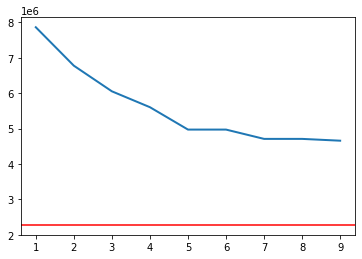

In [33]:
# plot


fig, ax = plt.subplots()
plt.axhline(y=2279204, color='r', linestyle='-')
ax.plot(x_axis, y_axis, linewidth=2.0, label = "LNS")



plt.show()

## Heurística sin copy

In [34]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np

x_axis = []
y_axis = []
soluciones = []
count=1
modelo = definir_modelo()
iter_time = time.time()
print("---tiempo clone: %s segundos ---" % (time.time() - iter_time))
q = 2
iteraciones = 10
for i in range(n_cargos):
    modelo.y[i+1].setlb(val = 1)
    modelo.y[i+1].setub(val = 1)
solver = SolverFactory('gurobi')
solver.solve(modelo)
solver.solve(modelo)
x = modelo.x.extract_values()
y = modelo.y.extract_values()
soluciones.append([i for i in x if x[i] == 1 if (i[0]<=n_cargos*2 and i[1]<=n_cargos*2)])
soluciones.append([i for i in y if y[i] == 1])
start_time = time.time()
while(count<iteraciones):
    iter_time = time.time()
    modelo = definir_modelo()
    modelo_seteado = random_removal_2(q, soluciones, modelo)
    soluciones = creation(modelo_seteado,solver)
    y_axis.append(modelo_seteado.obj())
    x_axis.append(count)
    print(f"valor objetivo: {modelo_seteado.obj()}")
    print(f"iteración: {count}")
    print("---tiempo iteración: %s segundos ---" % (time.time() - iter_time))
    print("---tiempo LNS: %s segundos ---\n\n" % (time.time() - start_time))
    count += 1

---tiempo clone: 0.0 segundos ---
cargos reasignados: [9, 8, 24, 23]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.0030002593994140625 segundos ---
---tiempo solve: 0.5772168636322021 segundos ---
valor objetivo: 7167744.0
iteración: 1
---tiempo iteración: 0.9302070140838623 segundos ---
---tiempo LNS: 0.9302070140838623 segundos ---


cargos reasignados: [7, 14, 22, 29]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.0030019283294677734 segundos ---
---tiempo solve: 0.5530247688293457 segundos ---
valor objetivo: 6277390.0
iteración: 2
---tiempo iteración: 1.2620422840118408 segundos ---
---tiempo LNS: 2.193246841430664 segundos ---


cargos reasignados: [4, 10, 19, 25]
---tiempo for: 0.0 segundos ---
---tiempo values: 0.0029435157775878906 segundos ---
---tiempo solve: 0.5780861377716064 segundos ---
valor objetivo: 5558466.0
iteración: 3
---tiempo iteración: 1.2030467987060547 segundos ---
---tiempo LNS: 3.3962936401367188 segundos ---


cargos reasignados: [14, 9, 29, 24]

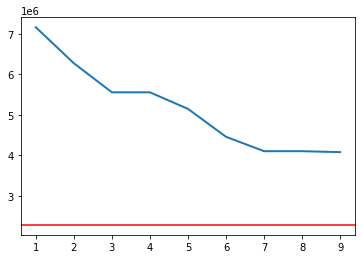

In [35]:
# plot


fig, ax = plt.subplots()
plt.axhline(y=2279204, color='r', linestyle='-')
ax.plot(x_axis, y_axis, linewidth=2.0, label = "LNS")



plt.show()

In [30]:
print("recorrido de barcos")
for i in modelo_seteado.x:
    if modelo_seteado.x[i].value == 1:
        print(i)
print("\n")
print("cargos asignados a spot")
for i in modelo_seteado.y:
    if modelo_seteado.y[i].value == 1:
        print(i)

recorrido de barcos
(3, 11, 1)
(18, 23, 1)
(5, 20, 4)
(20, 38, 4)
(8, 18, 1)
(23, 35, 1)
(9, 24, 2)
(24, 15, 2)
(10, 25, 3)
(25, 37, 3)
(11, 26, 1)
(26, 8, 1)
(15, 30, 2)
(30, 36, 2)
(31, 3, 1)
(32, 9, 2)
(33, 10, 3)
(34, 5, 4)


cargos asignados a spot
1
2
4
6
7
12
13
14
